In [14]:
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [15]:
# Helpers (runs faster than numpy stuff)
def cross(a, b):
    return np.array([a[1]*b[2]-a[2]*b[1],
                     a[2]*b[0]-a[0]*b[2],
                     a[0]*b[1]-a[1]*b[0]], dtype=np.float32)

In [16]:
# ========== BORIS METHOD ==========
def boris_update(x, v, B, dU, h):
    B_val = B(x)
    E_val = dU(x)

    v_minus = v + (h*0.5) * E_val
    t       = 0.5*h * B_val
    t_dot_t = t[0] * t[0] + t[1] * t[1] + t[2] * t[2]
    s       = 2.0  * t / (1.0 + t_dot_t)

    v_prime = v_minus + cross(v_minus, t)
    v_plus  = v_minus + cross(v_prime, s)
    v[:]    = v_plus + (h*0.5) * E_val
    x[:]    = x + h * v           

def init_v_minus_half(x0, v0, B, dU, h):
    B_val = B(x0)
    E_val = dU(x0)

    a = np.cross(v0, B_val) - E_val
    return v0 - 0.5*h * a

def integrate_boris(x0, v_minus_half, nsteps, B, dU, h):
    X = np.empty((nsteps+1, 3), dtype=np.float32)
    V = np.empty((nsteps+1, 3), dtype=np.float32)
                        
    x = x0.copy()
    v = v_minus_half.copy()
    X[0, :] = x
    V[0, :] = v

    for i in trange(1, nsteps+1):
        boris_update(x, v, B, dU, h)
        X[i, :] = x
        V[i, :] = v

    return X, V

# ========== RUNGE-KUTTA METHOD ==========
def runge_kutta_update(x, v, B, dU, h):
    # TODO
    pass

def integrate_runge_kutta(x0, v0, nsteps, B, dU, h):
    X = np.empty((nsteps+1, 3), dtype=np.float32)
    V = np.empty((nsteps+1, 3), dtype=np.float32)
                        
    x = x0.copy()
    v = v0.copy()
    X[0, :] = x
    V[0, :] = v

    for i in trange(1, nsteps+1):
        runge_kutta_update(x, v, B, dU, h)
        X[i, :] = x
        V[i, :] = v

    return X, V

# ========== FORTH-ORDER SYMMETRIC MULTISTEP METHOD ==========
def fo_multi_update(x, v, B, dU, h):
    # TODO
    pass

def integrate_fo_multi(x0, v0, nsteps, B, dU, h):
    X = np.empty((nsteps+1, 3), dtype=np.float32)
    V = np.empty((nsteps+1, 3), dtype=np.float32)
                        
    x = x0.copy()
    v = v0.copy()
    X[0, :] = x
    V[0, :] = v

    for i in trange(1, nsteps+1):
        fo_multi_update(x, v, B, dU, h)
        X[i, :] = x
        V[i, :] = v

    return X, V

In [17]:
# Define the two systems
def B_2D(x):
    r2 = x[0]*x[0] + x[1]*x[1]
    r  = np.sqrt(r2)
    return np.array([0.0, 0.0, r], dtype=np.float32)

def dU_2D(x):
    r2 = x[0]*x[0] + x[1]*x[1]
    r  = np.sqrt(r2)
    invr = 0.0 if r == 0.0 else 1.0/r
    return np.array([0.01*x[0]*invr, 0.01*x[1]*invr, 0.0], dtype=np.float32)

def B_tokamak(x):
    r2 = x[0]*x[0] + x[1]*x[1]
    r  = np.sqrt(r2)
    inv2r2 = 0.5 / r2
    inv2r  = 0.5 / r
    Bx = -(2.0*x[1] + x[0]*x[2]) * inv2r2
    By =  (2.0*x[0] - x[1]*x[2]) * inv2r2
    Bz = (r - 1.0) * inv2r
    return np.array([Bx, By, Bz], dtype=np.float32)

def dU_tokamak(x):
    return np.zeros(3, dtype=np.float32)


100%|██████████| 1000000/1000000 [00:14<00:00, 68292.18it/s]


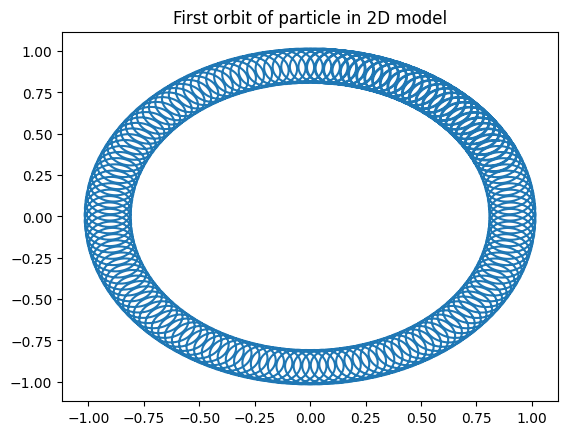

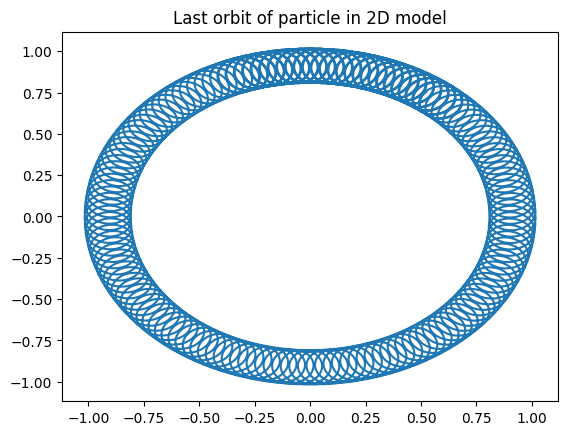

100%|██████████| 1000000/1000000 [00:14<00:00, 71354.35it/s]


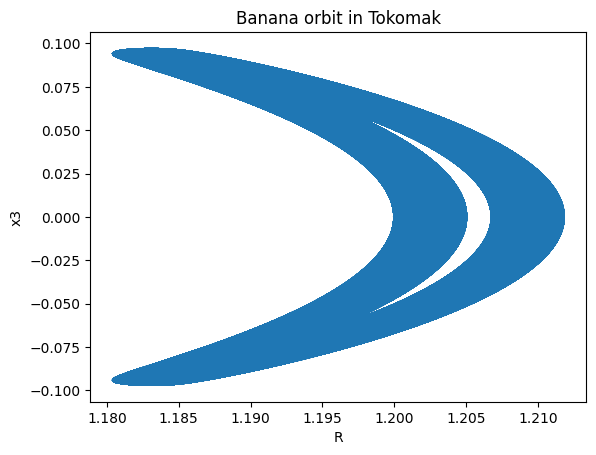

In [20]:
# ===============================================
# Run numerical integration for different solvers
# ===============================================
h      = 0.1
T_max  = 1e5
nsteps = int(T_max / h)

# 2D charged particle
orbit_time_2d = int(1.2e3 / h)
x0_2d = np.array([0.0, 1.0, 0.1])
v0_2d = np.array([0.09, 0.05, 0.20])

# Tokamak magnetic field
x0_tokamak = np.array([1.2, 0.0, 0.0])
v0_tokamak = np.array([0, 4.816e-4, -2.059e-3])

# ===== Boris =====
# 2D
v_mhalf = init_v_minus_half(x0_2d, v0_2d, B_2D, dU_2D, h)
X_vals_boris, V_vals_boris = integrate_boris(x0_2d, v_mhalf, nsteps, B_2D, dU_2D, h)

orbit_time = int(1.2e3 / h)
plt.figure()
plt.title("First orbit of particle in 2D model")
plt.plot(X_vals_boris[:orbit_time_2d,0], X_vals_boris[:orbit_time_2d,1])
plt.show()

plt.figure()
plt.title("Last orbit of particle in 2D model")
plt.plot(X_vals_boris[-orbit_time_2d:,0], X_vals_boris[-orbit_time_2d:,1])
plt.show()

# Tokamak
v_mhalf = init_v_minus_half(x0_tokamak, v0_tokamak, B_tokamak, dU_tokamak, h)
X_vals_boris, V_vals_boris = integrate_boris(x0_tokamak, v0_tokamak, nsteps, B_tokamak, dU_tokamak, h)

R = np.sqrt(X_vals_boris[:,0]**2 + X_vals_boris[:,1]**2)
plt.figure()
plt.plot(R, X_vals_boris[:,2])
plt.title("Banana orbit in Tokomak")
plt.xlabel('R'); plt.ylabel('x3')
plt.show()

# # ===== Runge-Kutta =====
# # 2D
# X_vals_rk, V_vals_rk = integrate_runge_kutta(x0, v0, nsteps, B_2D, dU_2D, h)

# plt.figure()
# plt.plot(X_vals_rk[:orbit_time_2d,0], X_vals_rk[:orbit_time_2d,1])
# plt.show()

# plt.figure()
# plt.plot(X_vals_rk[-orbit_time_2d:,0], X_vals_rk[-orbit_time_2d:,1])
# plt.show()

# # Tokamak
# X_vals_rk, V_vals_rk = integrate_boris(x0, v0, nsteps, B_tokamak, dU_tokamak, h)

# R = np.sqrt(X_vals_rk[:,0]**2 + X_vals_rk[:,1]**2)
# plt.figure()
# plt.plot(R, X_vals_rk[:,2])
# plt.xlabel('R'); plt.ylabel('x3')
# plt.show()

# # ===== Forth-Order Symmetric Multistep =====
# # 2D
# X_vals_fo, V_vals_fo = integrate_fo_multi(x0, v0, nsteps, B_2D, dU_2D, h)

# plt.figure()
# plt.plot(X_vals_fo[:orbit_time_2d,0], X_vals_fo[:orbit_time_2d,1])
# plt.show()

# plt.figure()
# plt.plot(X_vals_fo[-orbit_time_2d:,0], X_vals_fo[-orbit_time_2d:,1])
# plt.show()

# # Tokamak
# X_vals_fo, V_vals_fo = integrate_fo_multi(x0, v0, nsteps, B_tokamak, dU_tokamak, h)

# R = np.sqrt(X_vals_fo[:,0]**2 + X_vals_fo[:,1]**2)
# plt.figure()
# plt.plot(R, X_vals_fo[:,2])
# plt.xlabel('R'); plt.ylabel('x3')
# plt.show()

In [19]:
# import numpy as np
# from scipy.integrate import solve_ivp
# import matplotlib.pyplot as plt

# # Lorentz-force RHS: ẋ = v, v̇ = v × B(x) − ∇U(x)
# def rhs(t, y):
#     x = y[:3]
#     v = y[3:]
#     B = B_tokamak(x)
#     dU = dU_tokamak(x)
#     dxdt = v
#     dvdt = np.cross(v, B) - dU
#     return np.concatenate((dxdt, dvdt))

# # ==========================
# #  Initial conditions
# # ==========================

# x0 = np.array([1.2, 0.0, 0.0], dtype=np.float64)
# v0 = np.array([0.0, 4.816e-4, -2.059e-3], dtype=np.float64)
# y0 = np.concatenate((x0, v0))

# # ==========================
# #  Integration parameters
# # ==========================

# T_max = 1e5     # shorten from 1e5 for testing; can increase later
# t_eval = np.linspace(0, T_max, 10000)

# sol = solve_ivp(rhs, [0, T_max], y0, method='RK45', t_eval=t_eval,
#                 rtol=1e-12, atol=1e-12)

# # ==========================
# #  Plot reference trajectory
# # ==========================

# X = sol.y[:3, :].T
# R = np.sqrt(X[:,0]**2 + X[:,1]**2)

# plt.figure()
# plt.plot(X[:,0], X[:,1])
# plt.xlabel('x1'); plt.ylabel('x2')
# plt.title('Tokamak reference trajectory (RK45)')
# plt.axis('equal')
# plt.show()

# plt.figure()
# plt.plot(R, X[:,2])
# plt.xlabel('R'); plt.ylabel('x3')
# plt.title('Banana orbit (reference)')
# plt.show()
